In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2_sets as mf2_sets
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2_sets_not0 as mf2_sets_TLO
from TO_sim.get_cluster import cluster_os_new2


from TO_sim.get_cluster import C_rsmso,cluster_os,C_rsmso_set_new
from TO_sim.To_Draw import Draw_avg_vel_r

from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
import parmap
from scipy.signal import find_peaks
from TO_sim.To_Draw import Draw_avg_vel_r
from tqdm.notebook import tqdm

In [55]:
m_set = np.arange(0.1,10+0.1/2,0.1).reshape(-1,1)
K = 0
seed = 11
N = 500
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
N_set = len(m_set)
omega = np.sort(omega) - np.mean(omega)
theta_sets = (np.ones((N_set,1))*theta_init)
# theta_sets = (np.ones((N_set,1))*np.ones_like(theta_init))
omega_sets = (np.ones((N_set,1))*omega)


# m = 10
t_end = 500
dt =0.1
t = np.arange(0,t_end,dt)
theta_set, dtheta_set,rs = mf2_sets_TLO(m_set = m_set,N=N,K=K,t_array=t,p_theta=theta_sets,p_dtheta= 0*omega_sets,p_omega=omega_sets,result_time=int((t_end-350)*(1/dt)))

In [150]:
def make_new_df(K_start,m_start,N = 500):
    cols ={'r':[0],'rstd':[0],'rMM':[0],'error':[0]}
    theta_col = []
    dtheta_col = []
    for i in range(10):
        cols[f'c{i}'] = np.nan
    for i in range(10):
        cols[f'c{i} phase vel'] = np.nan
    for i in range(10):
        cols[f'c{i} omega'] = np.nan
    for i in range(10):
        cols[f'c{i} list'] = np.nan

    for i in range(N):
        s = 'theta'+f'{i}'.zfill(3)
        theta_col.append(s)
        cols[s]= np.nan

    for i in range(N):
        s = 'dtheta'+f'{i}'.zfill(3)
        dtheta_col.append(s)
        cols[s]= np.nan

    cols['K'] = K_start
    cols['m'] = m_start
    df = pd.DataFrame(cols)
    df_Km = df.set_index(['K','m'])
    for i in range(10):
        df_Km[f'c{i} list'] =df_Km[f'c{i} list'].astype(object)
    return df_Km,theta_col,dtheta_col

In [109]:
def hysterisis_col(df_Km,sets,theta_col,dtheta_col,K,m_set):
    theta_set,dtheta_set,rs = sets
    r_duration = rs[-5000:,:]
    r = np.mean(r_duration,axis=0)
    rstd = np.std(r_duration,axis=0)
    rMM = (np.max(r_duration,axis=0)-np.min(r_duration,axis=0))

    sum_time = 1500
    dtheta_c = np.cumsum(dtheta_set,axis=0)
    avg_dtheta_set = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time

    r_duration = rs.T[0].T[-sum_time:]
    mean_rs = np.mean(r_duration,axis=0)
    mean_rs_std = np.std(r_duration,axis=0)
    rMM = (np.max(r_duration,axis=0)-np.min(r_duration,axis=0)).reshape(-1)
    N_set = len(m_set)

    dtype = [('cluster size', int), ('cluster mean phase velocity', float)]
    dtype2 = [('cluster size', int), ('cluster mean natural frequency', float)]

    c_threshold = np.where(mean_rs<0.05,1e-5,5e-4)
    last_theta = theta_set[-1]
    last_dtheta = dtheta_set[-1]
    for i,m in enumerate(m_set.reshape(-1)):
            AVG = avg_dtheta_set[-1500:,i]
            df_Km.loc[(K,m),"r"] = r[i]
            df_Km.loc[(K,m),"rstd"] = rstd[i]
            df_Km.loc[(K,m),"rMM"] = rMM[i]
            c_check = c_threshold[i]
            CS,CMP,cluster,omega_s,omega_e,CMO,Is_group,C_s,C_e = cluster_os_new2(AVG=AVG,check=c_check,c_size=5,N=N,omega=omega)
            CSMP = np.array([(S,P) for S,P in zip(CS,CMP)],dtype=dtype)
            CSMO = np.array([(S,O) for S,O in zip(CS,CMO)],dtype=dtype2)
            for i in range(len(CSMP)):
                    df_Km.loc[(K,m),f'c{i}'] = CSMP['cluster size'][i]
                    df_Km.loc[(K,m),f'c{i} phase vel'] = CSMP['cluster mean phase velocity'][i]
                    df_Km.loc[(K,m),f'c{i} omega'] = CSMO['cluster mean natural frequency'][i]
            df_Km.loc[(K,m),theta_col] = last_theta[i]
            df_Km.loc[(K,m),dtheta_col] = last_dtheta[i]
    return (last_theta,last_dtheta)

In [58]:
df_Km,theta_col,dtheta_col = make_new_df(K,m_set[0],N = 500)

In [59]:
(last_theta,last_dtheta) = hysterisis_col(df_Km,(theta_set, dtheta_set,rs),theta_col,dtheta_col)

In [80]:
for _ in tqdm(list(range(28))):
    K = K +0.1
    theta_set, dtheta_set,rs = mf2_sets_TLO(m_set = m_set,N=N,K=K,t_array=t,p_theta=last_theta,p_dtheta=last_dtheta,p_omega=omega_sets,result_time=int((t_end-350)*(1/dt)))
    (last_theta,last_dtheta) = hysterisis_col(df_Km,(theta_set, dtheta_set,rs),theta_col,dtheta_col,K,m_set)

  0%|          | 0/28 [00:00<?, ?it/s]

In [40]:
dtheta_set[-1][0].shape

(500,)

In [78]:
Ks[-1]

7.099999999999991

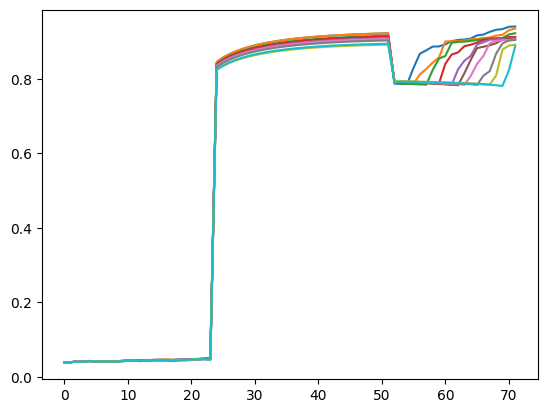

In [97]:
for i in range(30,40):
    plt.plot(df_Km.sort_index().r.unstack().to_numpy()[:,i]);

In [79]:
100 -72

28

In [245]:
check_list_m = []
check_list_K = []

for i in range(0):
    ms = df_Km.reset_index().m.unique()
    re_df = df_Km.reset_index()

    df_m = re_df[re_df.m == ms[i]]
    Ks = df_m.K.to_numpy()
    rs = df_m.r.to_numpy()
    rstd = df_m.rstd.to_numpy()
    rMM= df_m.rMM.to_numpy()
    cluster_s = df_m.iloc[:,5:15]
    cluster_o = df_m.iloc[:,15:25]
    len_cluster = (~cluster_o.isna()).sum(axis=1).to_numpy()
    plt.scatter(np.ones((10,72))*Ks,cluster_s.to_numpy().T,alpha=0.9,
                c=np.ones((10,72))*(len_cluster),s=5*np.ones((10,72))*(len_cluster))
    # plt.colorbar()
    len_cluster = (~cluster_o.isna()).sum(axis=1)
    is_na = df_m.K.loc[df_m.K>2][len_cluster ==0].to_numpy()
    if len(is_na) !=0:
        # print(ms[i],is_na)
        for K in is_na:
            check_list_K.append(K)
            check_list_m.append(ms[i])



In [246]:
Ks

array([0.])

In [38]:
cluster_o.to_numpy().shape

(6, 10)

In [33]:
len(m_set)

99

In [11]:
theta_sets.shape

(99, 500)

In [8]:
theta_set[-1].shape

(99, 500)

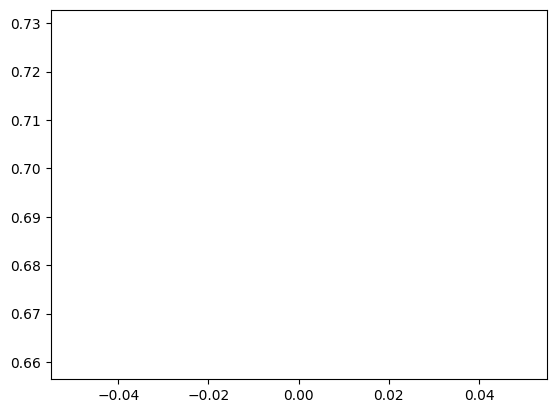

In [46]:
plt.plot(rs.T[0].T);

In [32]:
m = 0

In [ ]:
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_init,p_dtheta= 0*omega,p_omega=omega,result_time = int((t_end)-(350))*int(1/dt))
if m == 0:
        dtheta = np.c_[dtheta[0],dtheta.T].T
r_c = np.cumsum(rs,axis=0)
sum_time = 150*int(1/dt)
t_sum = t[sum_time:]
avg_r_set = (r_c[sum_time:]-r_c[:-sum_time])/sum_time

r_duration = rs[-5000:]
r = np.mean(r_duration,axis=0)
rstd = np.std(r_duration,axis=0)
rMM = (np.max(r_duration,axis=0)-np.min(r_duration,axis=0))

sum_time = 1500
dtheta_c = np.cumsum(dtheta,axis=0)
avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time

c_threshold = np.where(r<0.1,1e-5,3e-4)
CS,CMP,cluster,omega_s,omega_e,CMO,Is_group,C_s,C_e = cluster_os_new2(AVG=avg_dtheta,check=c_threshold,c_size=5,N=N,omega=omega)
dtype = [('cluster size', int), ('cluster mean phase velocity', float)]
dtype2 = [('cluster size', int), ('cluster mean natural frequency', float)]
CSMP = np.array([(S,P) for S,P in zip(CS,CMP)],dtype=dtype)
CSMO = np.array([(S,O) for S,O in zip(CS,CMO)],dtype=dtype2)


df_Km.loc[(K,m),"r"] = r
df_Km.loc[(K,m),"rstd"] = rstd
df_Km.loc[(K,m),"rMM"] = rMM
df_Km.loc[(K,m),'error'] = np.nan
for i in range(len(CSMO)):
        df_Km.loc[(K,m),f'c{i}'] = CSMP['cluster size'][i]
        df_Km.loc[(K,m),f'c{i} phase vel'] = CSMP['cluster mean phase velocity'][i]
        df_Km.loc[(K,m),f'c{i} omega'] = CSMO['cluster mean natural frequency'][i]
df_Km.loc[(K,m),theta_col] = last_theta[i]
df_Km.loc[(K,m),dtheta_col] = last_dtheta[i]
df_Km.loc[(K,m),cluster] = cluster

In [183]:
def hysterisis(df_Km,sets,theta_col,dtheta_col,K,m):
    theta,dtheta,rs = sets
    r_duration = rs[-5000:]
    r = np.mean(r_duration,axis=0)
    rstd = np.std(r_duration,axis=0)
    rMM = (np.max(r_duration,axis=0)-np.min(r_duration,axis=0))

    sum_time = 1500
    dtheta_c = np.cumsum(dtheta,axis=0)
    avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time

    c_threshold = np.where(r<0.1,1e-5,1e-4)
    CS,CMP,cluster,omega_s,omega_e,CMO,Is_group,C_s,C_e = cluster_os_new2(AVG=avg_dtheta,check=c_threshold,c_size=5,N=N,omega=omega)
    dtype = [('cluster size', int), ('cluster mean phase velocity', float)]
    dtype2 = [('cluster size', int), ('cluster mean natural frequency', float)]
    CSMP = np.array([(S,P) for S,P in zip(CS,CMP)],dtype=dtype)
    CSMO = np.array([(S,O) for S,O in zip(CS,CMO)],dtype=dtype2)
    cluster = np.array(cluster)
    last_theta = theta[-1]
    last_dtheta = dtheta[-1]
    df_Km.loc[(K,m),"r"] = r
    df_Km.loc[(K,m),"rstd"] = rstd
    df_Km.loc[(K,m),"rMM"] = rMM
    df_Km.loc[(K,m),'error'] = np.nan
    for i in range(len(CSMO)):
        df_Km.loc[(K,m),f'c{i}'] = CSMP['cluster size'][i]
        df_Km.loc[(K,m),f'c{i} phase vel'] = CSMP['cluster mean phase velocity'][i]
        df_Km.loc[(K,m),f'c{i} omega'] = CSMO['cluster mean natural frequency'][i]
        df_Km.loc[(K,m),f'c{i} list'] = ' '.join(map(str,cluster[i]))
    df_Km.loc[(K,m),theta_col] = last_theta
    df_Km.loc[(K,m),dtheta_col] = last_dtheta
    return (last_theta,last_dtheta) 

In [280]:
seed = 10
N = 500
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
omega = np.sort(omega) - np.mean(omega)

K = 0
m = 0
dK = 0.1
K_end = 10
Ks = np.arange(0,K_end+dK/2,dK)

df_Km,theta_col,dtheta_col = make_new_df(0,m,N = N)

def TLO(m,theta_init,omega,Ks,N,df_Km,theta_col,dtheta_col):
    t_end = 500
    dt =0.1
    t = np.arange(0,t_end,dt)
    K = Ks[0]
    theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_init,p_dtheta= 0*omega,p_omega=omega,result_time = int((t_end)-(350))*int(1/dt))
    if m == 0:
        dtheta = np.c_[dtheta[0],dtheta.T].T
    last_theta,last_dtheta = hysterisis(df_Km,(theta, dtheta,rs),theta_col,dtheta_col,K,m)
    for K in Ks[1:]:
        theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=last_theta,p_dtheta= last_dtheta,p_omega=omega,result_time = int((t_end)-(350))*int(1/dt))
        if m == 0:
            dtheta = np.c_[dtheta[0],dtheta.T].T
        last_theta,last_dtheta = hysterisis(df_Km,(theta, dtheta,rs),theta_col,dtheta_col,K,m)

In [282]:
TLO(0,theta_init,omega,Ks,N,df_Km,theta_col,dtheta_col)
TLO(0.1,theta_init,omega,Ks,N,df_Km,theta_col,dtheta_col)

In [271]:
pd.merge(df_Km.reset_index(),df_Km1.reset_index(),how='outer').set_index(['K','m'])

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_82666/1917162146.py:1: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  pd.merge(df_Km.reset_index(),df_Km1.reset_index(),how='outer').set_index(['K','m'])
/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_82666/1917162146.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.merge(df_Km.reset_index(),df_Km1.reset_index(),how='outer').set_index(['K','m'])


,,r,rstd,rMM,error,c0,c1,c2,c3,c4,c5,...,dtheta490,dtheta491,dtheta492,dtheta493,dtheta494,dtheta495,dtheta496,dtheta497,dtheta498,dtheta499
K,m,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.036970,0.019776,0.120249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.194040e+00,2.210857e+00,2.288117e+00,2.353115e+00,2.353957e+00,2.363694e+00,2.373316e+00,2.434315e+00,2.436641e+00,2.648900e+00
0.1,0.0,0.039411,0.021245,0.131108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.187057e+00,2.219361e+00,2.295720e+00,2.357850e+00,2.345866e+00,2.354958e+00,2.364766e+00,2.430126e+00,2.438150e+00,2.657339e+00
0.2,0.0,0.043170,0.022297,0.116606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.196710e+00,2.213769e+00,2.288149e+00,2.350176e+00,2.356857e+00,2.363053e+00,2.371049e+00,2.436473e+00,2.437525e+00,2.650167e+00
0.3,0.0,0.044332,0.024213,0.134112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.209600e+00,2.206677e+00,2.284615e+00,2.362632e+00,2.347011e+00,2.369321e+00,2.361638e+00,2.434130e+00,2.420832e+00,2.665639e+00
0.4,0.0,0.047506,0.025753,0.157875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.183567e+00,2.224400e+00,2.271649e+00,2.367540e+00,2.350504e+00,2.379926e+00,2.379610e+00,2.430202e+00,2.452889e+00,2.632705e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.6,0.1,0.995062,0.000002,0.000123,NaN,500.0,NaN,NaN,NaN,NaN,NaN,...,-1.397320e-11,6.014432e-12,1.802515e-11,1.465191e-11,-2.538557e-13,6.727431e-12,1.079028e-11,-5.676700e-12,-1.181002e-11,-1.564906e-11
9.7,0.1,0.995165,0.000002,0.000119,NaN,500.0,NaN,NaN,NaN,NaN,NaN,...,1.567908e-11,1.817781e-11,8.688753e-13,6.577775e-12,1.047334e-11,-2.126895e-12,2.922356e-12,-9.150071e-12,4.154633e-13,3.067226e-11
9.8,0.1,0.995265,0.000002,0.000115,NaN,500.0,NaN,NaN,NaN,NaN,NaN,...,1.570150e-11,-7.226087e-12,1.266085e-11,1.677843e-11,1.697644e-11,-7.458777e-12,1.190228e-11,1.068562e-11,-1.130250e-11,2.414807e-11


In [251]:
df_Km,theta_col,dtheta_col = make_new_df(0,0,N = 500)

In [253]:
for i in tqdm(list(range(10))):
    K = Ks[0]
    # clear_output(wait=True)
    theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_init,p_dtheta= 0*omega,p_omega=omega,result_time = int((t_end)-(350))*int(1/dt))
    if m == 0:
        dtheta = np.c_[dtheta[0],dtheta.T].T
    last_theta,last_dtheta = hysterisis(df_Km,(theta, dtheta,rs),theta_col,dtheta_col,K,m)
    for K in Ks[1:]:
        theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=last_theta,p_dtheta= last_dtheta,p_omega=omega,result_time = int((t_end)-(350))*int(1/dt))
        if m == 0:
            dtheta = np.c_[dtheta[0],dtheta.T].T
        last_theta,last_dtheta = hysterisis(df_Km,(theta, dtheta,rs),theta_col,dtheta_col,K,m)
    print(K,m)
    m +=0.1

  0%|          | 0/10 [00:00<?, ?it/s]

now K = 0.00 m = 0.00
10.09999999999998 0
now K = 0.00 m = 0.10
10.09999999999998 0.1
now K = 0.00 m = 0.20


KeyboardInterrupt: 

In [201]:
df_Km['c0 list']
from IPython.display import clear_output
clear_output(wait=True)

In [239]:
df_Km.sort_index().r.unstack().to_numpy().shape

(102, 4)

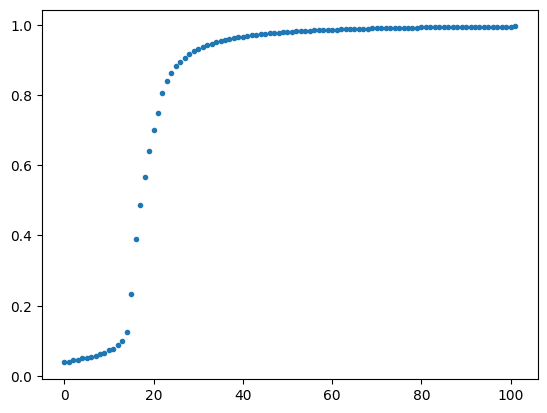

In [254]:
plt.plot(df_Km.sort_index().r.unstack().to_numpy()[:,0],'.');


In [247]:
df_Km.sort_index().reset_index().K

0       0.0
1       0.0
2       0.0
3       0.0
4       0.1
       ... 
231     9.9
232    10.0
233    10.0
234    10.1
235    10.1
Name: K, Length: 236, dtype: float64

IndexError: index 4 is out of bounds for axis 1 with size 4

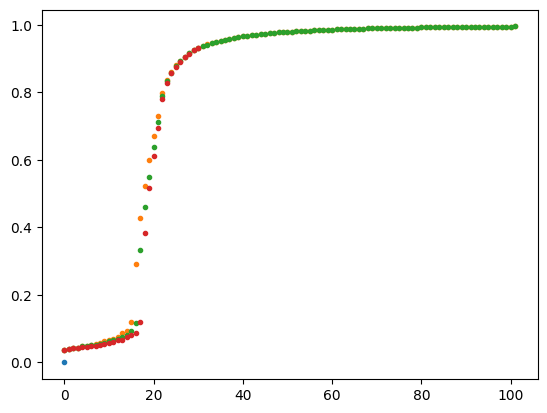

In [242]:
for i in range(10):
    plt.plot(df_Km.sort_index().r.unstack().to_numpy()[:,i],'.');

## paramap test

In [16]:
import numpy as np
import pandas as pd
from TO_sim.TLO import TLO,make_new_df
from TO_sim.gen_Distribution import Normal
from parmap import parmap
import matplotlib.pyplot as plt

In [5]:
K_start = 0
m_start = 0
df_Km,theta_col,dtheta_col = make_new_df(K_start,m_start,N = 500)

In [11]:
seed = 10
N = 500
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
omega = np.sort(omega) - np.mean(omega)
ms = np.arange(0,10+0.05,0.1)
K = 0
m = 0
dK = 0.1
K_end = 10
Ks = np.arange(0,K_end+dK/2,dK)

df_Km,theta_col,dtheta_col = make_new_df(0,m,N = N)
df_Km = df_Km.reset_index()

In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
num = 1

In [30]:

m_set = []
core = 8
index_ = 0
for i in range(len(ms)//core +1):
    m_set.append(ms[index_:index_+core])
    index_ += core
core_set = [len(ms) for ms in m_set]

In [33]:
for core,ms in zip(core_set[2:],m_set[2:]):
    for df in parmap.map(TLO,ms,
                        theta_init=theta_init,omega=omega,Ks=Ks,N=N,
                        t_end=500,dt = 0.1,pm_pbar=True, pm_processes=core):
        df_Km = df_Km.merge(df.reset_index(),how='outer')

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [34]:
df_Km.set_index(['K','m']).sort_index()

r      rstd       rMM error     c0    c1    c2    c3   c4  \
K    m                                                                        
0.0  0.0    0.03697  0.019776  0.120249   NaN    NaN   NaN   NaN   NaN  NaN   
     0.1   0.036966  0.019778  0.120249   NaN    NaN   NaN   NaN   NaN  NaN   
     0.2   0.036962   0.01978  0.120249   NaN    NaN   NaN   NaN   NaN  NaN   
     0.3   0.036957  0.019783  0.120249   NaN    NaN   NaN   NaN   NaN  NaN   
     0.4   0.036954  0.019786  0.120249   NaN    NaN   NaN   NaN   NaN  NaN   
...             ...       ...       ...   ...    ...   ...   ...   ...  ...   
10.0 9.6   0.702065  0.118137  0.372454   NaN  377.0  10.0   NaN   NaN  NaN   
     9.7   0.742652  0.080796  0.284451   NaN  394.0  30.0  10.0   NaN  NaN   
     9.8   0.712003   0.10646   0.36383   NaN  380.0  49.0  31.0  10.0  NaN   
     9.9   0.724316  0.095963  0.347091   NaN  386.0   NaN   NaN   NaN  NaN   
     10.0  0.755978   0.07312  0.273724   NaN    398    29   NaN   NaN  NaN   

            c5  ... dtheta490 dtheta491 dtheta492 dtheta493 dtheta494  \
K    m          ...                                                     
0.0  0.0   NaN  ...   2.19404  2.210857  2.288117  2.353115  2.353957   
     0.1   NaN  ...   2.19404  2.210857  2.288117  2.353115  2.353957   
     0.2   NaN  ...   2.19404  2.210857  2.288117  2.353115  2.353957   
     0.3   NaN  ...   2.19404  2.210857  2.288117  2.353115  2.353957   
     0.4   NaN  ...   2.19404  2.210857  2.288117  2.353115  2.353957   
...        ...  ...       ...       ...       ...       ...       ...   
10.0 9.6   NaN  ...  2.617088  2.606328  2.549631  2.493987  2.493222   
     9.7   NaN  ...  2.340662  2.324126  2.253206  2.198023  2.197331   
     9.8   NaN  ...  2.545916  2.550076  2.559114  2.557323  2.557256   
     9.9   NaN  ...  2.521675  2.530108  2.562515  2.581917   2.58212   
     10.0  NaN  ...  2.642179  2.643561  2.630774  2.604336  2.603909   

          dtheta495 dtheta496 dtheta497 dtheta498 dtheta499  
K    m                                                       
0.0  0.0   2.363694  2.373316  2.434315  2.436641    2.6489  
     0.1   2.363694  2.373316  2.434315  2.436641    2.6489  
     0.2   2.363694  2.373316  2.434315  2.436641    2.6489  
     0.3   2.363694  2.373316  2.434315  2.436641    2.6489  
     0.4   2.363694  2.373316  2.434315  2.436641    2.6489  
...             ...       ...       ...       ...       ...  
10.0 9.6   2.484303  2.475347   2.41526  2.412854  3.000057  
     9.7   2.189374   2.18159  2.134227  2.132497  2.482182  
     9.8   2.556413   2.55545  2.546479  2.546039  2.883478  
     9.9   2.584378  2.586442  2.595484  2.595684  2.388122  
     10.0  2.598831  2.593534  2.553318  2.551546  2.296247  

[10201 rows x 1044 columns]

In [9]:
pd.DataFrame(columns = ['r','rstd','rMM'])

,r,rstd,rMM


In [10]:
a = {'in':[],'dsaf':[]}

In [12]:
pd.DataFrame(columns=a.keys())

,in,dsaf


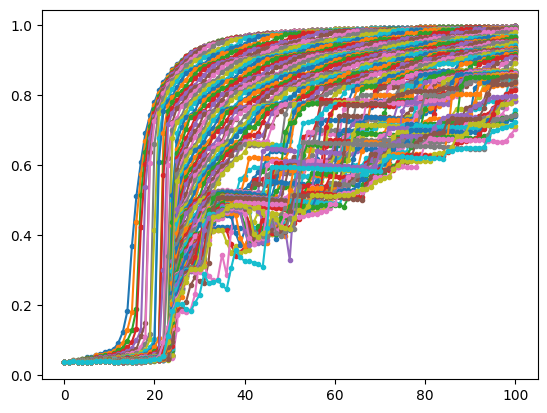

In [40]:
for i in range(100):
    plt.plot(df_Km.r.unstack().to_numpy()[:,i],'.-');

In [39]:
df_Km = df_Km.set_index(['K','m']).sort_index()

In [ ]:
ㅇㄹ

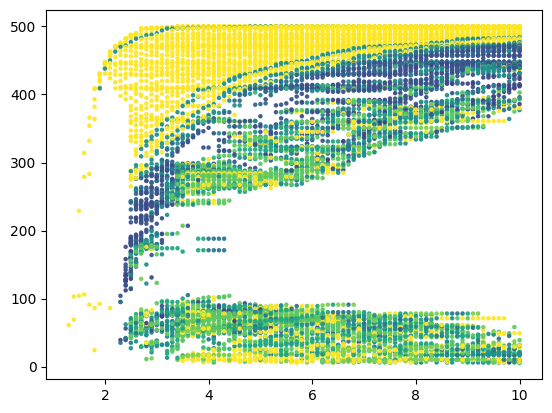

In [46]:
check_list_m = []
check_list_K = []

for i in range(100):
    ms = df_Km.reset_index().m.unique()
    re_df = df_Km.reset_index()

    df_m = re_df[re_df.m == ms[i]]
    Ks = df_m.K.to_numpy()
    rs = df_m.r.to_numpy()
    rstd = df_m.rstd.to_numpy()
    rMM= df_m.rMM.to_numpy()
    cluster_s = df_m.iloc[:,5:15]
    cluster_o = df_m.iloc[:,15:25]
    len_cluster = (~cluster_o.isna()).sum(axis=1).to_numpy()
    plt.scatter(np.ones((10,101))*Ks,cluster_s.to_numpy().T,alpha=0.9,
                c=np.ones((10,101))*(len_cluster),s=5)
    # plt.colorbar()
    len_cluster = (~cluster_o.isna()).sum(axis=1)
    is_na = df_m.K.loc[df_m.K>2][len_cluster ==0].to_numpy()
    if len(is_na) !=0:
        # print(ms[i],is_na)
        for K in is_na:
            check_list_K.append(K)
            check_list_m.append(ms[i])



In [55]:
dt = 0.1

In [56]:
df_Km.sort_index().to_excel(f'N = {N} seed = {seed} dt = {dt} TLO.xlsm')

In [47]:
df = df_Km.copy()

1
0
2
3
2
6
10
9
8
5


Text(0.5, 0, 'Coupling constant : $K$')

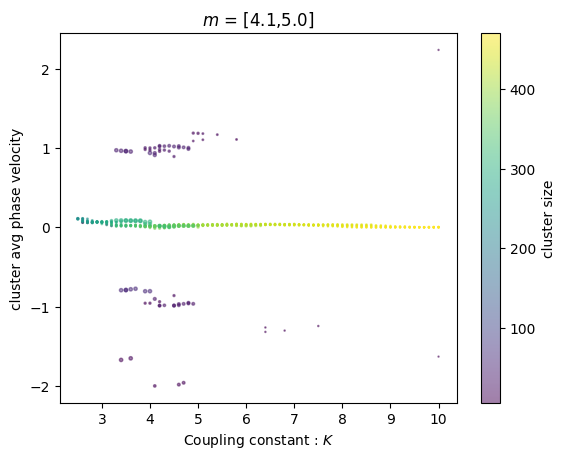

In [53]:
m_i,m_end = 41,51
for i in range(m_i,m_end):
    m_idx = i
    ms = df.reset_index().m.unique()
    re_df = df.reset_index()

    df_m = re_df[re_df.m == ms[m_idx]]
    Ks = df_m.K.to_numpy()
    rs = df_m.r.to_numpy()
    rstd = df_m.rstd.to_numpy(dtype=float)
    rMM= df_m.rMM.to_numpy()
    cluster_s = df_m.iloc[:,5:15]
    cluster_o = df_m.iloc[:,15:25]
    print(len(cluster_s['c1'].dropna()))
    plt.scatter(np.ones((10,101))*Ks,(cluster_o.to_numpy().T),c=cluster_s.to_numpy().T,alpha=0.5,
                s=50*np.ones((10,101))*rstd)
cbar = plt.colorbar()
cbar.set_label('cluster size')
plt.title(f'$m$ = [{ms[m_i]:.01f},{ms[m_end-1]:.01f}]')
plt.ylabel(r'cluster avg phase velocity')
plt.xlabel(r'Coupling constant : $K$')

In [ ]:
num = 0 
for K,CSO in zip(K_set.reshape(-1),CSO_set):
    try:
        if (len(CSO) > 0)&(num==0):
            num +=1
            print('start',K)

        x = CSO['cluster mean phase velocity']
        s = CSO['cluster size']
        if (K>2)&(len(s)==0):
            print('empty',K)
        if (K>2)&(len(s)>1):
            print('len',len(s),K)
        if (K<2)&(len(s)!=0):
            print('Nope',K)
        plt.scatter([K]*len(x),x,s=0.5*s,c=len(s)*np.ones_like(s),vmin=0,vmax=10)
    except ValueError:
        print('ValueError',K)
    # plt.xlim(2,3)

## By column

In [68]:
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2_sets_not0 as mf2_sets_TLO
from TO_sim.get_cluster import cluster_os_new2


In [66]:
m_set = np.arange(0.1,10+0.1/2,0.1).reshape(-1,1)
K = 0
seed = 11
N = 500
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
N_set = len(m_set)
omega = np.sort(omega) - np.mean(omega)
theta_sets = (np.ones((N_set,1))*theta_init)
# theta_sets = (np.ones((N_set,1))*np.ones_like(theta_init))
omega_sets = (np.ones((N_set,1))*omega)


# m = 10
t_end = 500
dt =0.1
t = np.arange(0,t_end,dt)
dK = 1
K_end = 10
Ks = np.arange(0,K_end+dK/2,dK)
# theta_set, dtheta_set,rs = mf2_sets_TLO(m_set = m_set,N=N,K=K,t_array=t,p_theta=theta_sets,p_dtheta= 0*omega_sets,p_omega=omega_sets,result_time=int((t_end-350)*(1/dt)))

In [59]:
def make_new_df(K_start,m_start,N = 500):
    cols ={'r':[0],'rstd':[0],'rMM':[0],'error':[0]}
    theta_col = []
    dtheta_col = []
    for i in range(10):
        cols[f'c{i}'] = np.nan
    for i in range(10):
        cols[f'c{i} phase vel'] = np.nan
    for i in range(10):
        cols[f'c{i} omega'] = np.nan
    for i in range(10):
        cols[f'c{i} list'] = np.nan

    for i in range(N):
        s = 'theta'+f'{i}'.zfill(3)
        theta_col.append(s)
        cols[s]= np.nan

    for i in range(N):
        s = 'dtheta'+f'{i}'.zfill(3)
        dtheta_col.append(s)
        cols[s]= np.nan

    cols['K'] = K_start
    cols['m'] = m_start
    df = pd.DataFrame(columns=cols.keys())
    df_Km = df.set_index(['K','m'])
    for i in range(10):
        df_Km[f'c{i} list'] =df_Km[f'c{i} list'].astype(object)
    return df_Km,theta_col,dtheta_col

In [60]:
def hysterisis_col(df_Km,sets,theta_col,dtheta_col,K,m_set,N,omega):
    theta_set,dtheta_set,rs = sets
    r_duration = rs[-5000:,:]
    r = np.mean(r_duration,axis=0)
    rstd = np.std(r_duration,axis=0)
    rMM = (np.max(r_duration,axis=0)-np.min(r_duration,axis=0))

    sum_time = 1500
    dtheta_c = np.cumsum(dtheta_set,axis=0)
    avg_dtheta_set = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time

    r_duration = rs.T[0].T[-sum_time:]
    mean_rs = np.mean(r_duration,axis=0)

    dtype = [('cluster size', int), ('cluster mean phase velocity', float)]
    dtype2 = [('cluster size', int), ('cluster mean natural frequency', float)]

    c_threshold = np.where(mean_rs<0.05,1e-5,1e-4)
    last_theta = theta_set[-1]
    last_dtheta = dtheta_set[-1]
    for i,m in enumerate(m_set.reshape(-1)):
            AVG = avg_dtheta_set[-1500:,i]
            df_Km.loc[(K,m),"r"] = r[i]
            df_Km.loc[(K,m),"rstd"] = rstd[i]
            df_Km.loc[(K,m),"rMM"] = rMM[i]
            c_check = c_threshold[i]
            CS,CMP,cluster,omega_s,omega_e,CMO,Is_group,C_s,C_e = cluster_os_new2(AVG=AVG,check=c_check,c_size=5,N=N,omega=omega)
            CSMP = np.array([(S,P) for S,P in zip(CS,CMP)],dtype=dtype)
            CSMO = np.array([(S,O) for S,O in zip(CS,CMO)],dtype=dtype2)
            for i in range(len(CSMP)):
                    df_Km.loc[(K,m),f'c{i}'] = CSMP['cluster size'][i]
                    df_Km.loc[(K,m),f'c{i} phase vel'] = CSMP['cluster mean phase velocity'][i]
                    df_Km.loc[(K,m),f'c{i} omega'] = CSMO['cluster mean natural frequency'][i]
                    df_Km.loc[(K,m),f'c{i} list'] = ' '.join(map(str,cluster[i]))
            df_Km.loc[(K,m),theta_col] = last_theta[i]
            df_Km.loc[(K,m),dtheta_col] = last_dtheta[i]
    return (last_theta,last_dtheta)

In [ ]:
df_Km,theta_col,dtheta_col = make_new_df(K,m_set[0],N = 500)
theta_set, dtheta_set,rs = mf2_sets_TLO(m_set = m_set,N=N,K=K,t_array=t,p_theta=theta_sets,p_dtheta= 0*omega_sets,p_omega=omega_sets,result_time=int((t_end-350)*(1/dt)))
(last_theta,last_dtheta) = hysterisis_col(df_Km,(theta_set, dtheta_set,rs),theta_col,dtheta_col)


In [82]:
def TLO_col(m_set,theta_init_set,omega_set,Ks,N,t_end=500,dt = 0.1):
    df_Km,theta_col,dtheta_col = make_new_df(0,m_set.reshape(-1)[0],N = N)
    t = np.arange(0,t_end,dt)
    K = Ks[0]
    theta_set, dtheta_set,rs = mf2_sets_TLO(m_set = m_set,N=N,K=K,t_array=t,p_theta=theta_init_set,p_dtheta= 0*omega_set,p_omega=omega_set,result_time=int((t_end-350)*(1/dt)))
    last_theta,last_dtheta = hysterisis_col(df_Km,(theta_set,dtheta_set,rs),theta_col,dtheta_col,K,m_set,N,omega)
    for K in Ks[1:]:
        theta_set,dtheta_set,rs = mf2_sets_TLO(m_set = m_set,N=N,K=K,t_array=t,p_theta=last_theta,p_dtheta= last_dtheta,p_omega=omega_set,result_time = int((t_end)-(350))*int(1/dt))
        last_theta,last_dtheta = hysterisis_col(df_Km,(theta_set,dtheta_set,rs),theta_col,dtheta_col,K,m_set,N,omega)
    return df_Km

In [74]:
len(Ks)

11

In [85]:
df_Km_2 = TLO_col(m_set,theta_init_set=theta_sets,omega_set=omega_sets,Ks=Ks,N=N,t_end=500,dt=0.1)

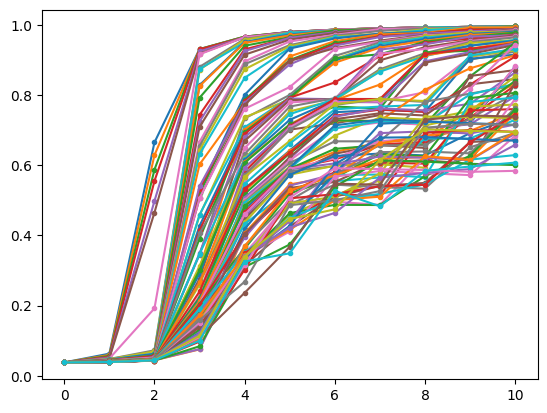

In [86]:
for i in range(100):
    plt.plot(df_Km_2.r.unstack().to_numpy()[:,i],'.-');

In [ ]:
for _ in tqdm(list(range(28))):
    K = K +0.1
    theta_set, dtheta_set,rs = mf2_sets_TLO(m_set = m_set,N=N,K=K,t_array=t,p_theta=last_theta,p_dtheta=last_dtheta,p_omega=omega_sets,result_time=int((t_end-350)*(1/dt)))
    (last_theta,last_dtheta) = hysterisis_col(df_Km,(theta_set, dtheta_set,rs),theta_col,dtheta_col,K,m_set)

  0%|          | 0/28 [00:00<?, ?it/s]

### TLO col test

In [1]:
import numpy as np
import pandas as pd
from TO_sim.TLO import TLO_col,make_new_df
from TO_sim.gen_Distribution import Normal
from parmap import parmap
import matplotlib.pyplot as plt

In [10]:
K_start = 0
m_start = 0
df_Km,theta_col,dtheta_col = make_new_df(K_start,m_start,N = 500)

In [13]:
m_set = np.arange(0.1,10+0.1/2,0.1).reshape(-1,1)
K = 0
seed = 10
N = 500
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
N_set = len(m_set)
omega = np.sort(omega) - np.mean(omega)
theta_sets = (np.ones((N_set,1))*theta_init)
# theta_sets = (np.ones((N_set,1))*np.ones_like(theta_init))
omega_sets = (np.ones((N_set,1))*omega)


# m = 10
t_end = 500
dt =0.1
t = np.arange(0,t_end,dt)
dK = 0.1
K_end = 10
Ks = np.arange(0,K_end+dK/2,dK)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
num = 1

In [14]:

ms_set = []
core = 8
index_ = 0
for i in range(len(m_set)//core +1):
    ms_set.append(m_set[index_:index_+core])
    index_ += core
core_set = [len(ms) for ms in ms_set]

In [15]:
core_set

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4]

In [16]:
for core,m_set in zip(core_set,ms_set):
    for df in parmap.map(TLO_col,m_set,theta_init_set=theta_sets,omega_set=omega_sets,Ks=Ks,N=N,t_end=500,dt=0.1
                         ,pm_pbar=True, pm_processes=core):
        df_Km = df_Km.merge(df.reset_index(),how='outer')

  0%|          | 0/8 [00:00<?, ?it/s]